In [1]:
#########################################################################
# Data Exploration - COVID-19 case trend analytics
# Created by George Zhao
# Note: this project needs to checkout the git:
# https://github.com/CSSEGISandData/COVID-19.git
# and has the project structure like this example:
# <Project_parent_home>
#    COVID-19/ (generated from "git clone https://github.com/CSSEGISandData/COVID-19.git" )
#    covid-19-analytics/ (generated from "git clone  https://github.com/chainmaporg/covid-19-analytics.git" )
# 
import pandas as pd
from IPython.display import display, HTML
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')




In [2]:
backdays = 10

In [3]:
## Utilities for the data engineering
##


def barchart(df, x_fld, y_fld, xlabel, ylabel, chartname):
    ax = sns.barplot(x=x_fld, y=y_fld, data=df,  palette=["lightblue"])   
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(chartname)
    #for p in ax.patches:
    #    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.xticks(rotation='vertical')
    #plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    plt.show()

def barchart2(df, x_fld, y_fld, huef, xlabel, ylabel, chartname):
    ax = sns.barplot(x=x_fld, y=y_fld, hue=huef, data=df, palette=["orange", "teal"]) 
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(chartname)
    #for p in ax.patches:
    #    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.xticks(rotation='vertical')
    #plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    plt.show()



def chart(daily_df, fld):
    t=daily_df.iloc[0]["region"]
    if(fld.find("_ratio")>0):
        ax = sns.lineplot(x="day", y=fld, data=daily_df)
    else:
        ax = sns.barplot(x="day", y=fld, data=daily_df, palette=["lightblue"])
    if(fld.find("_growth")>0):
        ylabel = "daily growth (%)"
    else:
        ylabel = "daily case count"
    
    ax.set(xlabel='Date ('+t+")", ylabel=ylabel)
    ax.set_title(fld+' number')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.xticks(rotation='vertical')

    plt.tight_layout()
    plt.show()

def linechart(daily_df, fld):
    t=daily_df.iloc[0]["region"]
    ax = sns.lineplot(x="day", y=fld, data=daily_df)
    if(fld.find("_growth")>0):
        ylabel = "daily growth (%)"
    else:
        ylabel = "daily case count"
    
    ax.set(xlabel='Date ('+t+")", ylabel=ylabel)
    ax.set_title(fld+' case')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.xticks(rotation='vertical')

    plt.tight_layout()
    plt.show()
    
def getDfFromLocal(filename):
        fullpath=filename
        df = pd.read_csv(fullpath, encoding="utf-8")
        return df
    
def printList(df):
    i=1
    for index, row in df.iterrows():
        print(i, row)
        i=i+1

def genDayList(days, off):
    now = datetime.datetime.now()
    daylist=[]
    for i in range(days):
        yesterday = date.today() - timedelta(days=(days-i+off))
        str = yesterday.strftime("%m-%d-%Y")
        daylist.append(str)
    return daylist


def getCountry(name):
    if(name=="US"):
        return("United States")
    else:
        return name
    
def getCountryPopulation(pop_df, country):
    country = getCountry(country)
    if(country.lower()=="china"):
        return 58.5*1000000
    for index, row in pop_df.iterrows():
        c=row["country"]
        c1=c.lower()
        c2=country.lower()

        if(c1.find(c2)>=0):
            return(row["population"])


In [4]:

## Data Process and data transforming
#
def findCountry():
    df = getDFByDay("03-27-2020")
    return df["Country_Region"].unique()


    
def findState():
    df = getDFByDay("03-27-2020")
    print(df["Province_State"].unique())

dfmap={}
def getDFByDay(day):
    global dfmap
    if(day in dfmap.keys()):
        return dfmap[day]
    
    file=day+".csv"
    filepath = "../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"+file
    df = getDfFromLocal(filepath)
    dfmap[day] = df
    return df


#output a list of cases by the day and tbe state name
def getCasesByState(day, state):
    df = getDFByDay(day)
    new_df = df[df['Province_State'].apply(lambda x: state == x)]
    return new_df

#Cover country/state/couty
def getTotalByRegion(day, region, isCountry):
    df = getDFByDay(day)
    if(region.find("-")>0):
        strs=region.split("-")
        county=strs[0]
        state=strs[1]
        df = df[df['Province_State'].apply(lambda x: state == x)]
        df = df[df['Admin2'].apply(lambda x: county == x)]
    elif isCountry:
        df = df[df['Country_Region'].apply(lambda x: region == x)]
    else:
        df = df[df['Province_State'].apply(lambda x: region == x)]
              
    return df




def getCasesByCounty(day, county, state):
    df = getCasesByState(day, state)
    new_df = df[df['Admin2'].apply(lambda x: county == x)]
    return new_df



def findCounty(state):
    df = getDFByDay("03-27-2020")
    df = df[df["Province_State"]==state]
    print(df.Admin2.unique())


def findTrendSpeedByCounty(day_list, county, state):
    region = county+"-"+state
    return findTrendSpeedByRegion(day_list, region, False)

def findTrendSpeedByState(day_list, state):
    return findTrendSpeedByRegion(day_list, state, False)

def findTrendByCountry(day_list, country):
    return findTrendSpeedByRegion(day_list, country, True)

def findTrendSpeedByCountry(day_list, country):
    return findTrendSpeedByRegion(day_list, country, True)


def findTrendSpeedByRegion(day_list, region, isCountry):
    
    d = {'region': [], 'day': [], 'confirmed': [],'confirmed_growth': [], 'death':[],'death_growth': [], 'recovered': [], 'recovered_ratio': [], 'death_ratio':[]}
    df = pd.DataFrame(d)

    i=0
    c0=0
    d0=0
    r0=0
    for day in day_list:
        day_df = getTotalByRegion(day, region, isCountry)
        if (day_df.shape[0]>0):
            c1 = day_df["Confirmed"].sum()
            d1 = day_df["Deaths"].sum()
            r1 = day_df["Recovered"].sum()
            dc1 = d1*1.0/c1
            
            if(c0>0):
                cc = (c1-c0)*100.0/c0
            else:
                cc = 0
                
            if(d0>0):
                dd = (d1-d0)*100.0/d0
            else:
                dd = 0               
 
            if(r0>0):
                rr = (r1)/c1
            else:
                rr = 0     
                
            new_row = [{"region":region, "day":day[:5], "confirmed":c1, 'confirmed_growth':cc, "death":d1, 'death_growth':dd, 'recovered':r1, 'recovered_ratio':rr, 'death_ratio':dc1}]
            c0=c1
            d0=d1
            r0=r1
        else:
            new_row = [{"region":region, "day":day[:5], "confirmed":0, 'confirmed_growth':0,   "death":0,  'death_growth':0, 'recovered':0, 'recovered_ratio':0, 'death_ratio':0}]
          
        df = df.append(new_row, ignore_index=True)
    return df  

    

In [5]:
def getTotalByRegion(day, region, isCountry):
    df = getDFByDay(day)
    if(region.find("-")>0):
        strs=region.split("-")
        county=strs[0]
        state=strs[1]
        df = df[df['Province_State'].apply(lambda x: state == x)]
        df = df[df['Admin2'].apply(lambda x: county == x)]
    elif isCountry:
        df = df[df['Country_Region'].apply(lambda x: region == x)]
    else:
        df = df[df['Province_State'].apply(lambda x: region == x)]
              
    return df



In [6]:
##Reporting and business layer
#

def chartGrowthDeath(df, title):
    numx = pd.melt(df, id_vars='day',
                         value_vars=["confirmed", "death"],
                         var_name="type", value_name="nums")

    barchart2(numx, "day","nums", "type", "Date", "Counts", title+":Confirmed Case/Death Growth")
def chartGR(df, title):
    numx = pd.melt(df, id_vars='day',
                         value_vars=["confirmed", "recovered"],
                         var_name="type", value_name="nums")

    barchart2(numx, "day","nums", "type", "Date", "Counts", title+":Confirmed Case/Recovered Growth")


def chartRegionAll(df1):
    chart(df1, "confirmed")
    chart(df1, "death")
    chart(df1, "confirmed_growth")
    chart(df1, "recovered")
    chart(df1, "recovered_ratio")
    chart(df1, "death_ratio")

def chartRegion(df1):
    chart(df1, "confirmed")
    chart(df1, "death")
    chart(df1, "confirmed_growth")
    chart(df1, "death_ratio")


def chartRegionWithTitle(title, df1):
    #chartGrowthDeath(df1, title)
    chartGR(df1, title)
    

def report_local():
    day_list = genDayList(backdays, 0)
    df1= findTrendSpeedByCounty(day_list, "Washington", "Oregon")
    chartRegion(df1)
    latest = day_list[len(day_list)-1]
    df1= getCasesByState(day_list[6], "Oregon")
    df1 =df1[["Admin2", "Province_State", "Confirmed", "Deaths"]]
    df1 = df1.sort_values(by=['Confirmed'], ascending=False) 
    df1= findTrendSpeedByState(day_list,"Oregon")
    chartRegion(df1)

def report_SC():
    day_list = genDayList(backdays, 0)
    df1= findTrendSpeedByCounty(day_list, "Santa Clara", "California")
    chartRegion(df1)
    latest = day_list[len(day_list)-1]
    df1= getCasesByState(day_list[6], "California")
    df1 =df1[["Admin2", "Province_State", "Confirmed", "Deaths"]]
    df1 = df1.sort_values(by=['Confirmed'], ascending=False) 
    df1= findTrendSpeedByState(day_list,"California")
    chartRegion(df1)


def report_NY():
    day_list = genDayList(backdays, 0)
    df = findTrendSpeedByState(day_list, "New York")
    chartRegion(df)
def report_US():
    day_list = genDayList(backdays, 0)
    df = findTrendSpeedByCountry(day_list, "US")
    chartRegionAll(df)

def report_top_growth():
    (topn_confirmed,topn_growth) = get_topn_world(20)
    clist = topn_confirmed['region'].tolist()
    for cty in clist:
        day_list = genDayList(backdays, 0)
        df = findTrendSpeedByCountry(day_list, cty)
        chartRegionWithTitle(cty, df) 
    
    
def report_world():
    day_list = genDayList(backdays, 0)
    clist = findCountry()
    for cty in clist: 
        if(cty=="China" or cty=="Korea, South" or cty=="Taiwan*"):
            df = findTrendSpeedByCountry(day_list, cty)
            #chartRegionAll(df)
            chartGrowthDeath(df)
            #k1 = df.iloc[len(day_list)-1]["confirmed_growth"]

def mydisplay(title, df):
    pd.set_option('display.width', -1)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', -1)
    display(HTML("<span style='color:red'><h2>"+title+"</h2> </span>  "))
    display(df)

def get_topn_world(n):
    day_list = genDayList(backdays, 0)
    clist = findCountry()
    d = {'region': [], 'confirmed': [],'confirmed_growth': [], 'death':[], 'recovered': [],'recovered_ratio': []}
    world_df= pd.DataFrame(d)
    for cty in clist:
        if(True):
            df = findTrendSpeedByCountry(day_list, cty)
            confirmed = df.iloc[len(day_list)-1]["confirmed"]
            confirmed_growth = df.iloc[len(day_list)-1]["confirmed_growth"]
            death = df.iloc[len(day_list)-1]["death"] 
            recovered=df.iloc[len(day_list)-1]["recovered"]
            recovered_ratio = recovered*1.0/confirmed
            new_row = [{"region":cty, "confirmed":confirmed, 'confirmed_growth':confirmed_growth,   'death':death, 'recovered':recovered, 'recovered_ratio': recovered_ratio}]       
            world_df = world_df.append(new_row)
            
    topn_confirmed = world_df.sort_values(by=['confirmed'], ascending=False)[:n]
    topn_growth = topn_confirmed.sort_values(by=['confirmed_growth'], ascending=False)[:n]
    return (topn_confirmed, topn_growth)


   
def top_world():
    (topn_confirmed, topn_growth) = get_topn_world(20)
    mydisplay("Top confirmed case countries", topn_confirmed)
    

def all_run(idx):
    if(idx==0):
        report_top_growth()
        
    if(idx==1):
        top_world()
    
    if(idx==7):
        report_US()
        #print("-------US DONE-----")
        
    if(idx==2):
        report_local()
        #print("-------LOCAL DONE-----")
    if(idx==3):
        report_NY()
        #print("-------NY DONE-----")
    if(idx==4):
        report_SC()
        #print("-------SC DONE-----")
    if(idx==5):
        report_world()
        #print("-------World DONE-----")
    if(idx==6):
        top_world()
        
    if(idx==8):
        (cdf, gdf) = get_topn_world(20)
        display(cdf.head(20))





<h1>COVID-19 04/10 Update</h1>

This reports covered the below cases
<br>
<b>Confirmed cases</b> - The total number is the key metrics, and its daily growth is monitored
<br>
<b>Number of Death cases</b> - Death can reflect to the status of Virus infection and medical capability
<br>
<b>Recoverd case</b> - Good news come from this number
<br>
<b>Recoverd ratio</b> - recovered/confirmed (0..1)
<br>
<b>Confirmed growth (%) </b> - The daily growth of the confirmed number (0..100)
<br>
<b>Death ratio</b> - The death ratio against the confirmed number (0..1)
<br>

How to read the report:

<ul>
    <li> Confirmed number - See the scope
    <li> Death numer - see how serious it is
    <li> Recovered number - see the ratio compaering to comnfirmed number
    <li> Confirmed growth - see the trend
    <li> Death ratio - see the growth can indicate medical capability too
</ul>

<h2> How to find good news from the report? </h2>
<ul>
    <li>Check the country overall confirmed growth to see the curve has been flatten
    <li>Check the death ratio to see if it is low
    <li>The up curve on recovered_ratio (0->1) is good, down is bad.
</ul>

<h2> Overview of global top-20 country situation on COVID-19</h2>


In [7]:
display(HTML("""
<style>
.output {
    align-items: center;
    text-align: center;
}
</style>
"""))


all_run(1)

,region,confirmed,confirmed_growth,death,recovered,recovered_ratio
0,US,496535.0,7.606239,18586.0,28790.0,0.057982
0,Spain,158273.0,3.296524,16081.0,55668.0,0.351721
0,Italy,147577.0,2.750895,18849.0,30455.0,0.206367
0,France,125931.0,6.019481,13215.0,25195.0,0.200070
0,Germany,122171.0,3.376177,2767.0,53913.0,0.441291
0,China,82941.0,0.069978,3340.0,77791.0,0.937908
0,United Kingdom,74605.0,13.257530,8974.0,588.0,0.007882
0,Iran,68192.0,2.977952,4232.0,35465.0,0.520076
0,Turkey,47029.0,11.227000,1006.0,2423.0,0.051521
0,Belgium,26667.0,6.740584,3019.0,5568.0,0.208797


<h2>Analytics on top-20 countries with most confirmed case </h2>

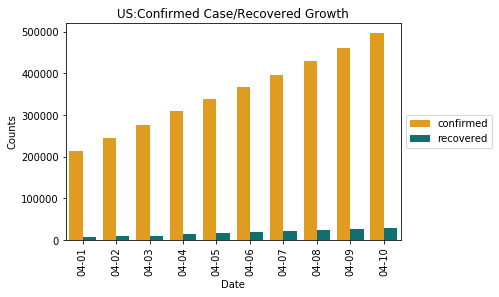

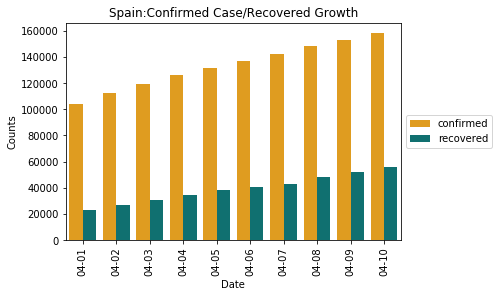

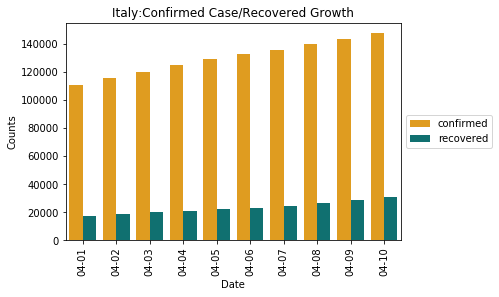

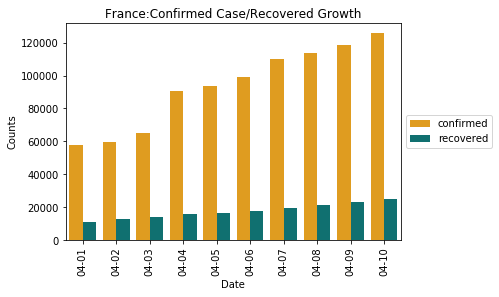

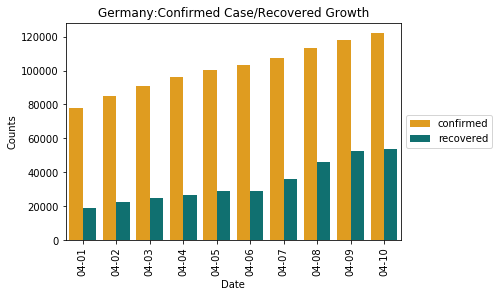

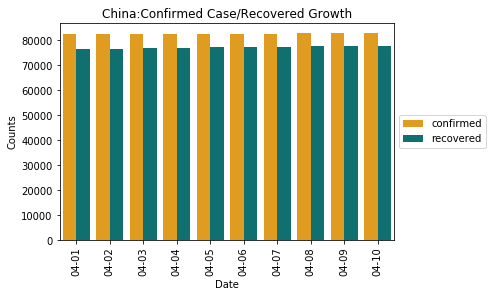

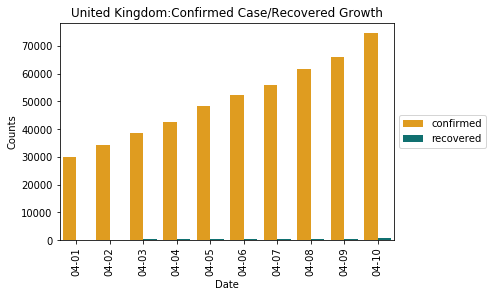

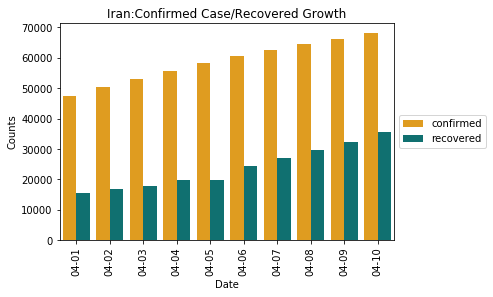

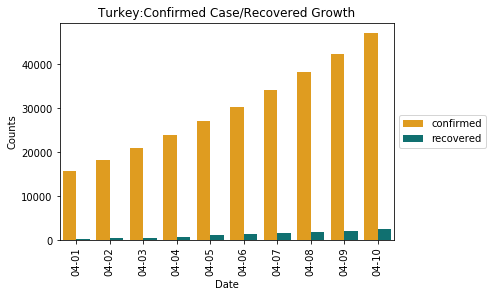

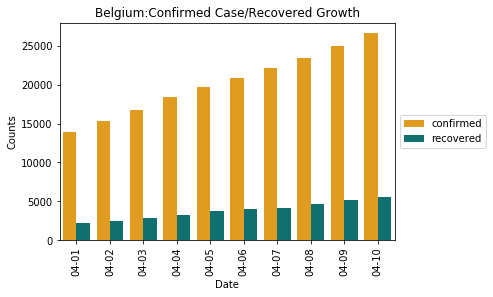

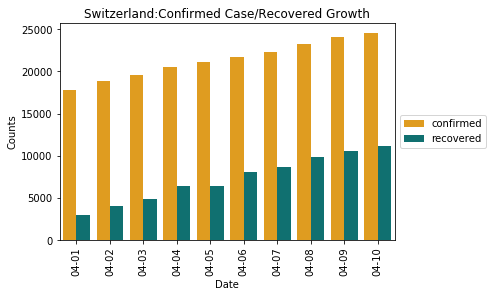

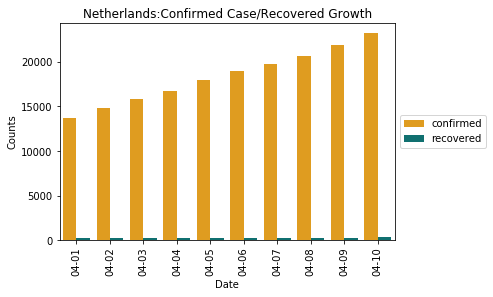

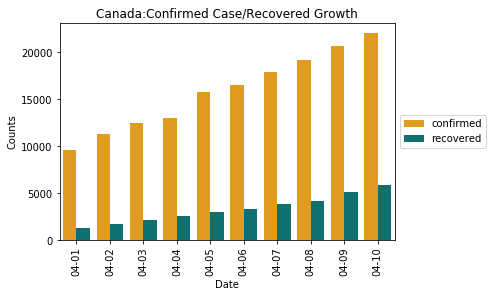

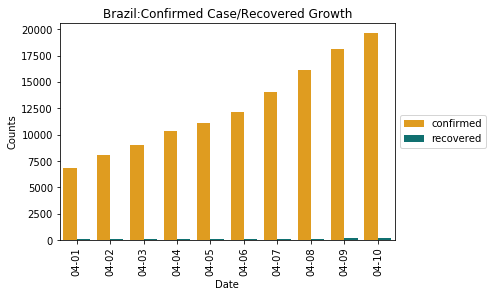

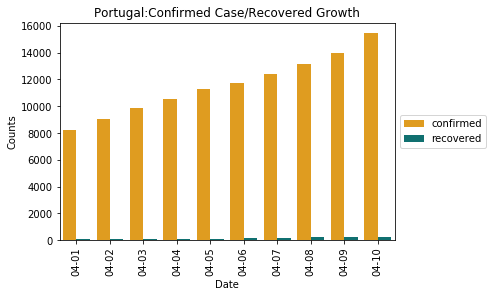

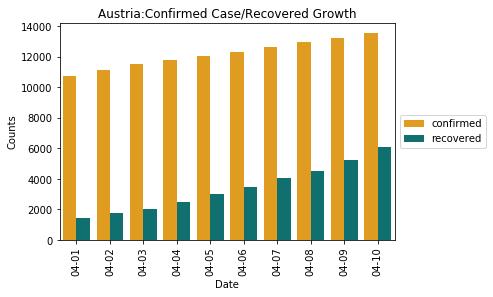

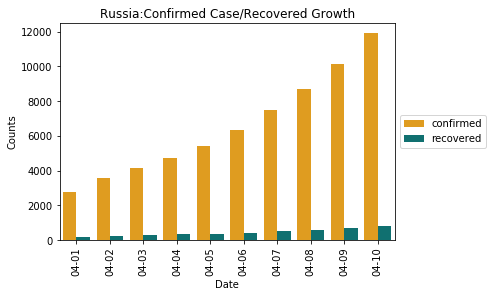

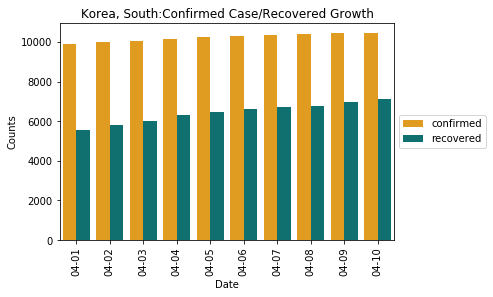

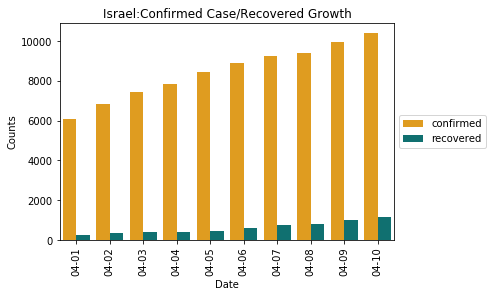

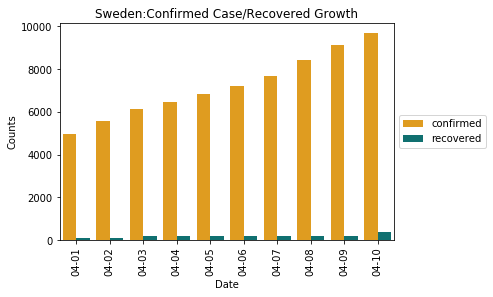

In [8]:
all_run(0)

<h2>US situation on COVID-19</h2>

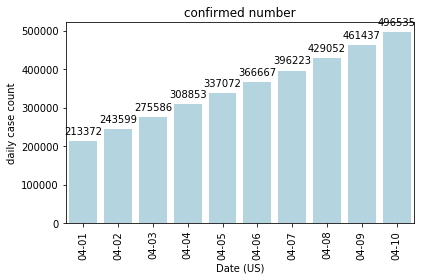

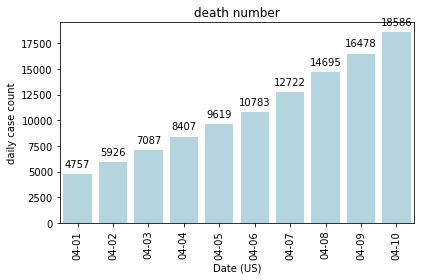

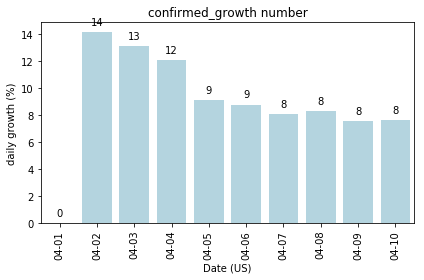

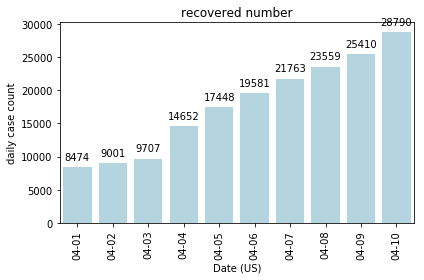

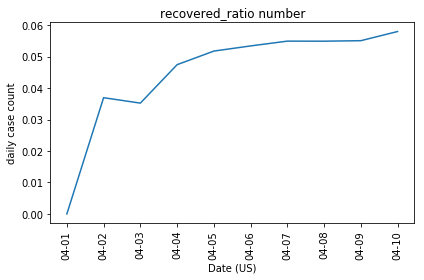

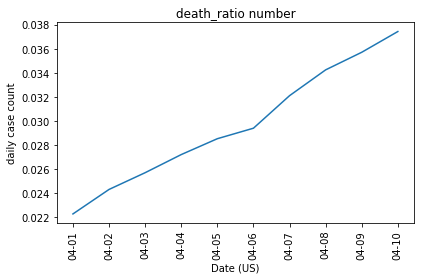

In [9]:
all_run(7)

<h2> Washington County, Oregon </h2>


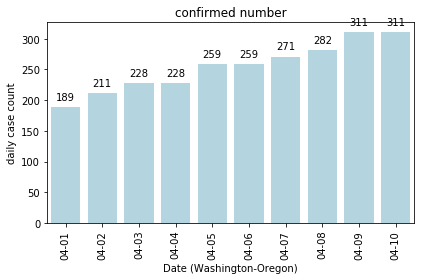

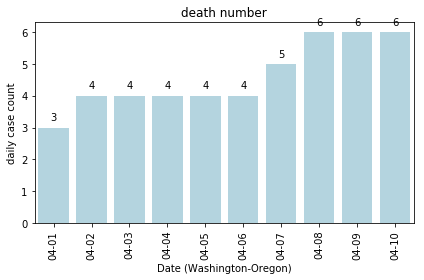

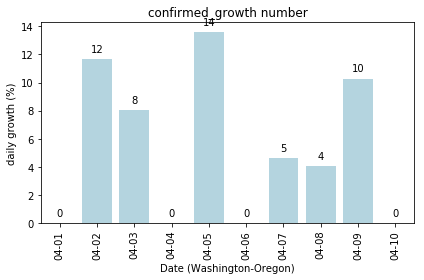

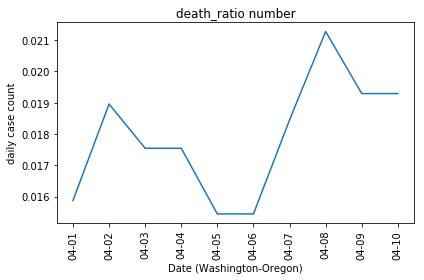

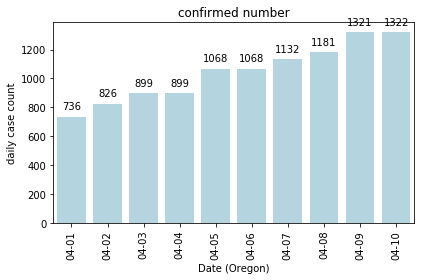

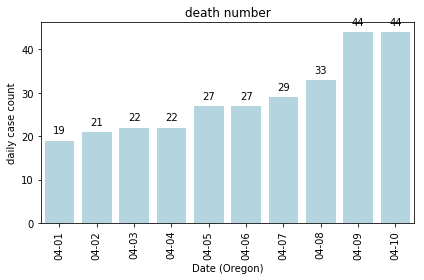

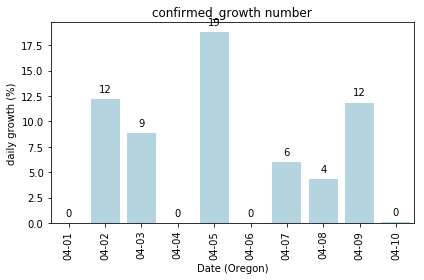

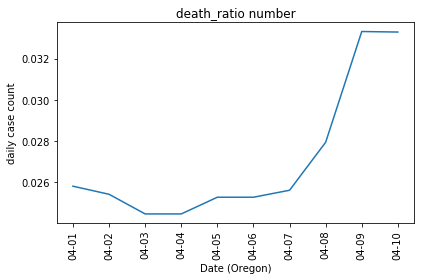

In [10]:
all_run(2)

<h2> Santa Clara, California </h2>

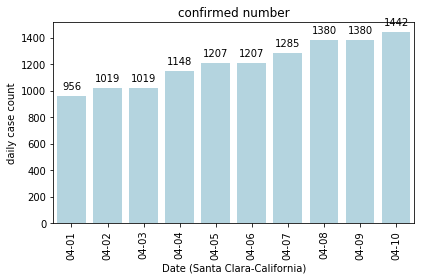

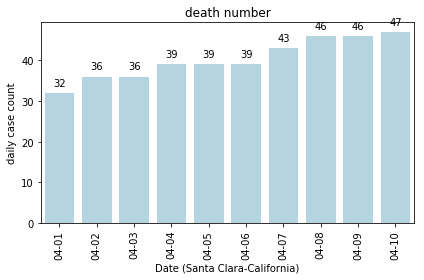

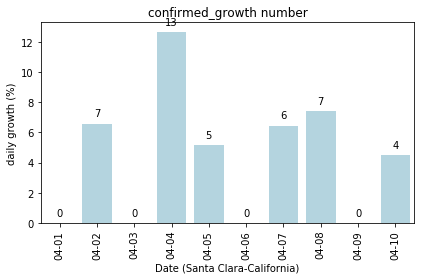

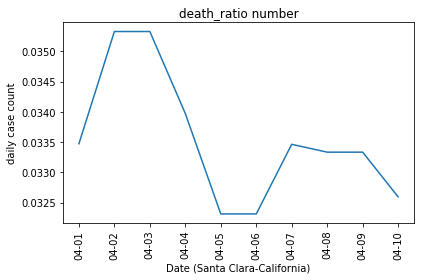

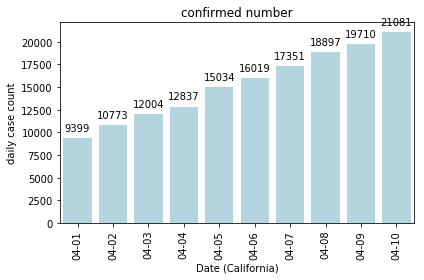

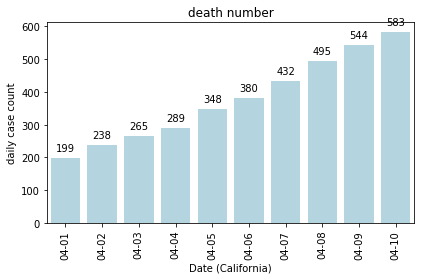

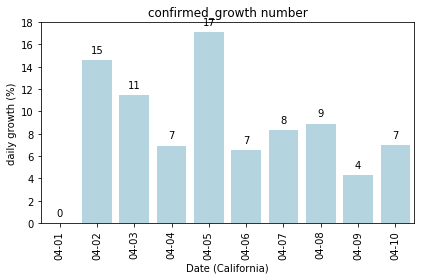

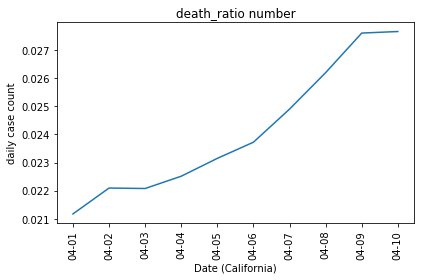

In [11]:
all_run(4)

<h2> New York </h2>

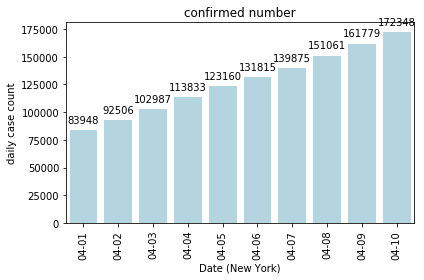

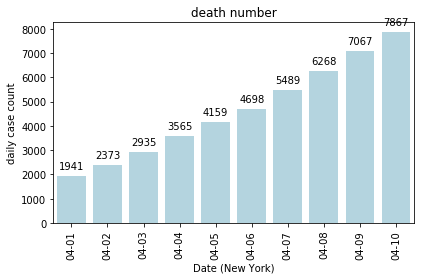

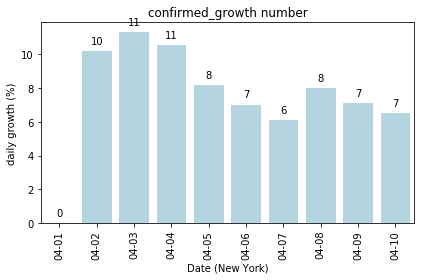

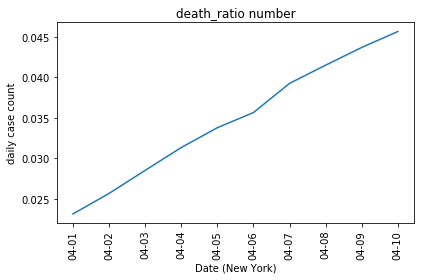

In [12]:
all_run(3)

In [13]:
## Testing code


    
def test1():
    df = getCasesByState("03-28-2020", "Oregon")
    sum_confirmed = df["Confirmed"].sum()
    sum_death = df["Deaths"].sum()
    print(sum_confirmed,sum_death)
    display(df.head(500))
    #printList(df)
    
def test2():
    df = getCasesByState("03-27-2020", "Oregon")
    sum_confirmed = df["Confirmed"].sum()
    sum_death = df["Deaths"].sum()
    print(sum_confirmed,sum_death)
    #display(df.head(500))
    #printList(df)
    
def test3():
    df = getCasesByState("03-22-2020", "Oregon")
    sum_confirmed = df["Confirmed"].sum()
    sum_death = df["Deaths"].sum()
    print(sum_confirmed,sum_death)
    #display(df.head(500))
    #printList(df)
    
def test4():
    daylist=["03-22-2020","03-23-2020","03-24-2020","03-25-2020","03-26-2020", "03-27-2020","03-28-2020"]
    df = findTrendSpeedByCounty(daylist, "Washington", "Oregon")
    chart(df, "confirmed")

def test5():
    #findState()
    #findCounty("California")
    day_list = genDayList(7, 1)
 
    df = findTrendSpeedByCounty(day_list, "Los Angeles", "California")
    #chart(df, "confirmed")
    display(df)
    
def test6():
    day_list = genDayList(7, 1)
 
    df1= findTrendSpeedByCounty(day_list, "Washington", "Oregon")
    chart(df1, "confirmed")
    chart(df1, "death")
        
    df = findTrendSpeedByState(day_list, "Oregon")
    chart(df, "confirmed")
    chart(df, "death")
    
    df = findTrendSpeedByCounty(day_list, "Los Angeles", "California")
    chart(df, "confirmed")
    chart(df, "death")
    
    df = findTrendSpeedByCounty(day_list, "Santa Clara", "California")
    chart(df, "confirmed")
    chart(df, "death")
    
    df = findTrendSpeedByState(day_list, "New York")
    chart(df, "confirmed")
    chart(df, "death")
    
    
    
    
    

def test7():
    #findCounty("California")
    #findState()
    findCountry()
    
def test8():
    day_list = genDayList(7, 1)
    df = findTrendSpeedByCountry(day_list, "US")
    chart(df, "confirmed")
    chart(df, "death")
    
def test9():
    day_list = genDayList(7, 1)
    df = findTrendSpeedByCountry(day_list, "US")
    chart(df, "confirmed")
    chart(df, "death")
    linechart(df, "confirmed_growth")
    linechart(df, "death_growth")
    df = findTrendSpeedByState(day_list, "Oregon")
    chart(df, "confirmed")
    chart(df, "death")
    linechart(df, "confirmed_growth")
    linechart(df, "death_growth")   
    df = findTrendSpeedByCounty(day_list, "Washington", "Oregon")
    chart(df, "confirmed")
    chart(df, "death")
    linechart(df, "confirmed_growth")
    linechart(df, "death_growth")   

def test10():
    day_list = genDayList(7, 1)
 
    df1= findTrendByCounty(day_list, "Washington", "Oregon")
    display(df1)
    chart(df1, "confirmed")
    chart(df1, "death")

def testall():
    print("1====================================")
    test10()
    print("2====================================")
    test9()
    print("3====================================")
    test8()
    print("4====================================")
    test6()
    print("5====================================")
    
#test5()


In [14]:
%%sh
#ls -lrt ../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/
#more ../csse_covid_19_data/csse_covid_19_daily_reports/04-01-2020.csv
#git pull
#more ../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
